In [ ]:
#instalacion de dependencias

In [ ]:
pip install dipy

In [ ]:
pip install fury

In [ ]:
pip install nibabel

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers


import nibabel as nib
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
AUTOTUNE = tf.data.AUTOTUNE

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
#from dipy.viz import window, actor
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.data as dpd
from google.colab import files
import time

In [5]:
#conexion a google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def plot_results_3_images(lowres, preds, highres):
    """
    Mostrar las 3 imágenes (lowres, preds, highres)
    """
    i = 0
    fig, axes = plt.subplots(1, 3, figsize=(25, 25))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    ax1, ax2, ax3 = axes
    ax1.imshow(lowres, cmap="gray")
    ax1.set_title('Ground Truth', fontsize=20)
    ax2.imshow(preds, cmap="gray")
    ax2.set_title('Bicubic', fontsize=20)
    ax3.imshow(highres, cmap="gray")
    ax3.set_title('EDSR', fontsize=20) 

In [7]:
def oneToThreeChannel(img, n):
  """
  recibe una imagen cuadrada de 1 canal y el numero de pixeles del lado
  retorna una imagen cuadrada de 3 canales asociada a la imagen de recepción
  """
  img3Channels = np.array([[np.array([np.single(0), np.single(0), np.single(0)]) for _ in range(n)] for _ in range(n)])
  for i in range(n):
    for j in range(n):
      pixel = img[i][j]
      img3Channels[i][j] = np.array([pixel, pixel, pixel])
  return img3Channels

In [8]:
def threeToOneChannel(img, n):
  """
  recibe una imagen cuadrada de 3 canales y el numero de pixeles del lado
  retorna una imagen cuadrada de 1 canal asociada a la imagen de recepcion
  """
  img1 = np.array([[np.array([np.single(0)]) for _ in range(n)] for _ in range(n)])
  for i in range(n):
    for j in range(n):
      pixel = img[i][j][0]
      img1[i][j] = np.array([pixel])
  return img1


In [9]:

def create_mask(img):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)

    # Calcular el umbral Otsu para la imagen en escala de grises
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)#cambio max

    # Encontrar los contornos de la imagen binaria
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar el contorno más grande
    max_contour = max(contours, key=cv2.contourArea)

    # Crear una imagen negra del mismo tamaño que la original
    mask = np.zeros_like(gray)

    # Dibujar el contorno más grande en blanco en la imagen negra
    cv2.drawContours(mask, [max_contour], 0, (255), -1)#cambio max

    # Dilatar la máscara para ampliar el área de recorte
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

def cut(img, mask):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    # Aplicar la máscara a la imagen original
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    return masked_img


In [10]:
def recortarSet(imagenes, mask):
  """
  aplicar una mascara de recorte mask en cada imagen de la lista imagenes
  """
  imagenes_recortadas = []
  for i in imagenes:
    imagenes_recortadas.append(cut(i, mask))
  return imagenes_recortadas

In [11]:
scale = 2 #escala de downsampling

#carga de dataset
filename = '/content/drive/MyDrive/ColabNotebooks/Data/TENSOR_2x2x2.nii'
images = nib.load(filename)
data = images.get_fdata()

#normalizacion
dataMax= data.max()
data = data/dataMax
data = data*255

#reduccion de resolucion
dataLow = data[0:data.shape[0]:scale,0:data.shape[1]:scale,:,:]

#cambio de ejes y reorganizacion del dataset(hr, lr) en una lista de imagenes
data = data.transpose(2,3,1, 0)
data = data.reshape(33*26, 256, 256) 
dataLow = dataLow.transpose(2,3,1, 0)
dataLow = dataLow.reshape(33*26, 128, 128) 

#conversion de imagenes(hr, lr) de 1 canal a 3 canales
data_3channel = []
for i in range(33*26):
  data_3channel.append(oneToThreeChannel(data[i],data[i].shape[0] ))

data_low_3channel = []
for i in range(33*26):
  data_low_3channel.append(oneToThreeChannel(dataLow[i],dataLow[i].shape[0] ))



In [12]:
mask = create_mask(data_3channel[480])
mask_low = create_mask(data_low_3channel[480])

In [14]:
#dividir el dataset en train, test y val
data_3channel = np.array(data_3channel)
data_low_3channel = np.array(data_low_3channel)

data_train, data_test, data_low_train, data_low_test = train_test_split(data_3channel, data_low_3channel, test_size=0.3, random_state=2024)
data_test, data_val, data_low_test, data_low_val = train_test_split(data_test, data_low_test, test_size=0.5, random_state=2024)

In [15]:
# Convertir las listas de matrices HR y LR en tensores de TensorFlow
train_HR_tensor = tf.convert_to_tensor(data_train, dtype=tf.float32)
train_LR_tensor = tf.convert_to_tensor(data_low_train, dtype=tf.float32)

val_HR_tensor = tf.convert_to_tensor(data_val, dtype=tf.float32)
val_LR_tensor = tf.convert_to_tensor(data_low_val, dtype=tf.float32)

# Crear un objeto tf.data.Dataset a partir de los tensores de HR y LR
dataset_train = tf.data.Dataset.from_tensor_slices((train_LR_tensor, train_HR_tensor))
dataset_val = tf.data.Dataset.from_tensor_slices((val_LR_tensor, val_HR_tensor))

# Definir la estructura del conjunto de datos
dataset_train = dataset_train.map(lambda x, y: ( x,  y))
dataset_val = dataset_val.map(lambda x, y: (x,  y))
#guardar datasets en cache
train_cache = dataset_train.cache()
val_cache = dataset_val.cache()

In [16]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=255)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=2):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    ) 

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale 

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [17]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=2), #scale estaba en 4
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


dataset_train = dataset_object(train_cache, training=True)
dataset_val = dataset_object(val_cache, training=False)



In [18]:

#recurso: https://keras.io/examples/vision/edsr/
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)#cambio max
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img




# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(32 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 1)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

model = make_model(num_filters=32, num_of_residual_blocks=16)

In [ ]:
NEpochs = 2000
Batch_size = 32

optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

# Registro de tiempo de inicio
tiempo_inicio = time.time()
model_train = model.fit(dataset_train, epochs=NEpochs, batch_size = Batch_size, steps_per_epoch= len(data_train)//Batch_size, validation_data=dataset_val)
# Registro de tiempo de finalización
tiempo_fin = time.time()

#grafica epocas vs Training loss y validation loss
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(NEpochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Cálculo del tiempo total de ejecución y salida del resultado
tiempo_total = tiempo_fin - tiempo_inicio
print("Tiempo total de ejecución: ", tiempo_total, " segundos")#Tiempo total de ejecución:  43589.72594809532  segundos

model.save("modelEDSR2000epochs.keras")
files.download("modelEDSR2000epochs.keras")

In [20]:

#cargar modelo entrenado
# Registrar la capa EDSRModel en el ámbito de objetos personalizados de Keras
#custom_objects = {'EDSRModel': EDSRModel, 'PSNR': PSNR}
# Cargar el modelo entrenado
#model = load_model('/content/drive/MyDrive/Colab Notebooks/modelos_entrenados/modelEDSR2000epochsSplit0.7.h5', custom_objects=custom_objects)


In [21]:
#metricas
def psnr(imagenesGT, imagenesPred):
  psnrGlobal = []
  for i in range(len(imagenesGT)):
    psnr = cv2.PSNR(imagenesGT[i], imagenesPred[i])
    psnrGlobal.append(psnr)
  psnrGlobal = np.array(psnrGlobal)
  return (psnrGlobal.mean(),psnrGlobal.std())


def rmse(imagenesGT, imagenesPred):
  rmseGlobal = []
  for i in range(len(imagenesGT)):
    rmse = np.sqrt(np.mean((imagenesGT[i] - imagenesPred[i])**2))
    rmseGlobal.append(rmse)
  rmseGlobal = np.array(rmseGlobal)
  return (rmseGlobal.mean(),rmseGlobal.std())

def mse(imagenesGT, imagenesPred):
  mseGlobal = []
  for i in range(len(imagenesGT)):
    mse = np.mean((imagenesGT[i] - imagenesPred[i])**2)
    mseGlobal.append(mse)
  mseGlobal = np.array(mseGlobal)
  return (mseGlobal.mean(),mseGlobal.std())

def ssim_(imagenesGT, imagenesPred):
  ssimGlobal = []
  for i in range(len(imagenesGT)):
    ssim_index = ssim(imagenesGT[i], imagenesPred[i], data_range=imagenesPred[i].max() - imagenesPred[i].min(), multichannel=True)
    ssimGlobal.append(ssim_index)
  ssimGlobal = np.array(ssimGlobal)
  return (ssimGlobal.mean(),ssimGlobal.std())

In [ ]:
#prediccion del conjunto de test
y = []
for i in range(len(data_low_test)):
  y.append(model.predict(data_low_test[i]))
y = np.array(y)
y = y.astype(np.float32)
mask = create_mask(data_3channel[480])
y_pred_recortadas =  recortarSet(y, mask)
data_3channel_recortadas =  recortarSet(data_test, mask)

In [ ]:
print("Metricas sin recorte")
valssim,stdssim = ssim_(data_test, y)
print('SSIM:', valssim, "standard deviation: ", stdssim)
valmse,stdmse = mse(data_test, y)
print('MSE:', valmse, "standard deviation: ", stdmse)
valrmse,stdrmse = rmse(data_test, y)
print('RMSE:', valrmse, "standard deviation: ", stdrmse)
valpsnr,stdpsnr = psnr(data_test, y)
print('PSNR:', valpsnr, "standard deviation: ", stdpsnr)

print("Metricas con recorte")
valssim,stdssim = ssim_(data_3channel_recortadas, y_pred_recortadas)
print('SSIM:', valssim, "standard deviation: ", stdssim)
valmse,stdmse = mse(data_3channel_recortadas, y_pred_recortadas)
print('MSE:', valmse, "standard deviation: ", stdmse)
valrmse,stdrmse = rmse(data_3channel_recortadas, y_pred_recortadas)
print('RMSE:', valrmse, "standard deviation: ", stdrmse)
valpsnr,stdpsnr = psnr(data_3channel_recortadas, y_pred_recortadas)
print('PSNR:', valpsnr, "standard deviation: ", stdpsnr)

In [37]:


#comparar contra interpolacion bicubica
data_bicubic = np.array(tf.image.resize(data_low_test, [256, 256], method='bicubic'))
data_bicubic = data_bicubic.astype(np.float32)

data_bicubic_rec = recortarSet(data_bicubic, mask)
#data_bicubic = np.array([resize_image(img) for img in data_low_3channel])
y_pred_recortadas =  recortarSet(data_bicubic, mask)



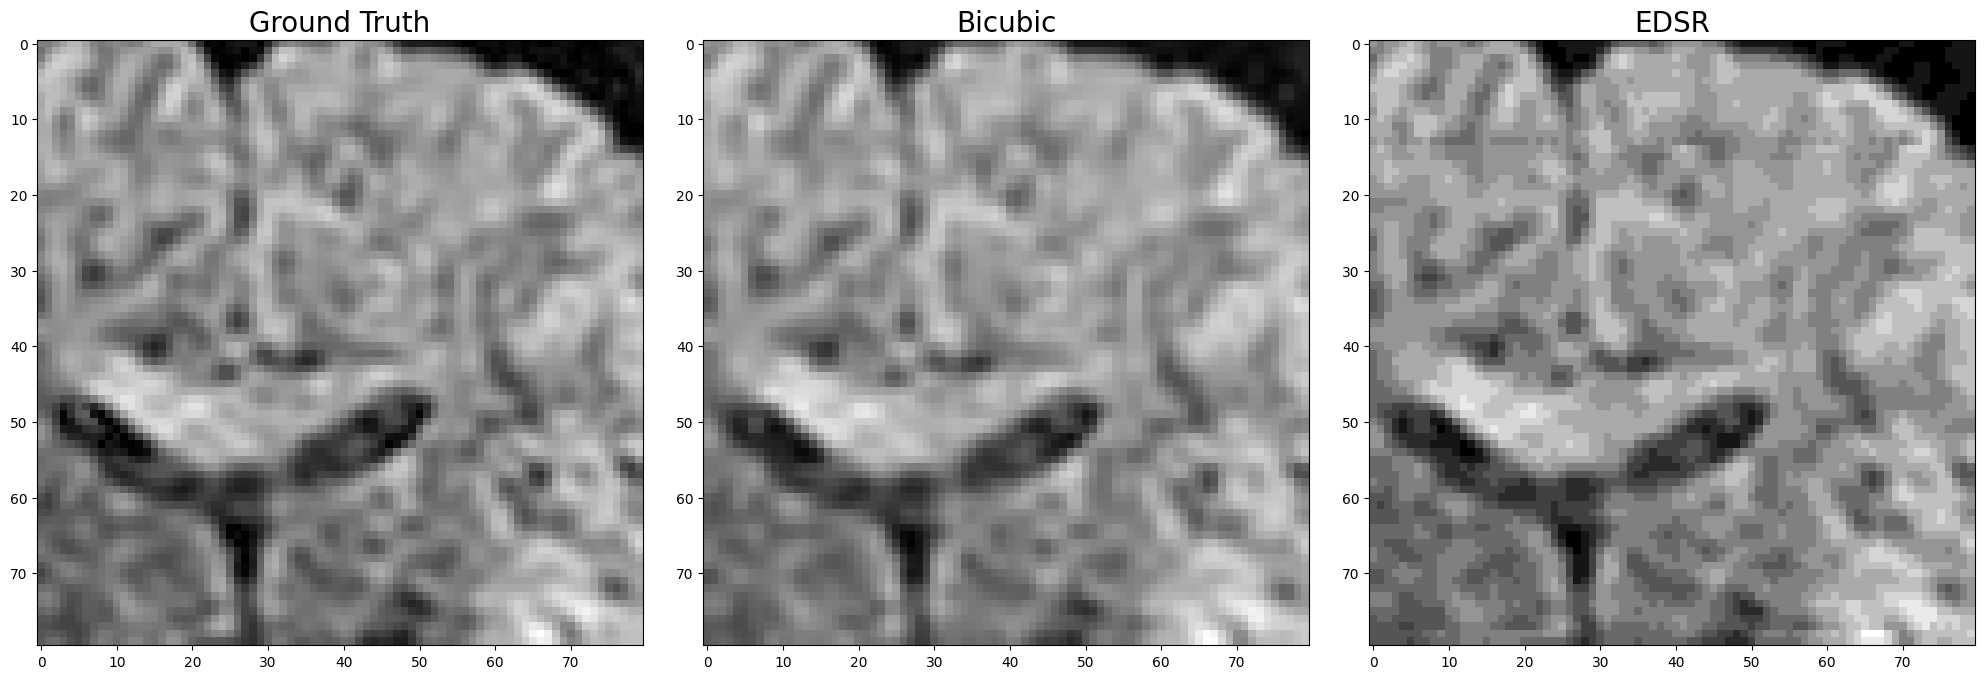

In [38]:
X = 1
plot_results_3_images(threeToOneChannel(data_test[X,50:130,100:180], 80), threeToOneChannel(data_bicubic[X,50:130,100:180], 80), threeToOneChannel(y[X,50:130,100:180], 80))


In [ ]:
#predecir todo el conjunto de datos
data_pred = []
for i in range(len(data_low_3channel)):
  data_pred.append(model.predict(data_low_3channel[i]))
data_pred = np.array(data_pred)
data_pred = data_pred.astype(np.float32)


In [40]:
data_pred_cut = []
for i in range(33*26):
  data_pred_cut.append(threeToOneChannel(data_pred[i],data_pred[i].shape[0] ))

In [41]:
data_cut_aux = np.array(recortarSet(data_3channel, mask))
data_cut = []
for i in range(33*26):
  data_cut.append(threeToOneChannel(data_cut_aux[i],data_cut_aux[i].shape[0] ))

In [42]:
def backTo4D(img):
  """
  Funcion que dado un conjunto de imagnes con dimensiones (858,256,256)
  lo convierte a (256,256,33,26)
  """
  nimg =  img.reshape(858,256,256)
  nimg = nimg.transpose(1,2,0)
  nimg = nimg.reshape(256,256,33,26)
  return nimg

In [43]:
bvals, bvecs = read_bvals_bvecs('/content/drive/MyDrive/ColabNotebooks/Data/TENSOR_2x2x2.bval', '/content/drive/MyDrive/ColabNotebooks/Data/TENSOR_2x2x2.bvec')


data_cut4 = backTo4D(np.array(data_cut))
gtab = gradient_table(bvals, bvecs)
tensorm = dti.TensorModel(gtab)
tenfitdata = tensorm.fit(data_cut4)

In [44]:
dataLow4 = backTo4D(np.array(data_pred_cut))
gtab = gradient_table(bvals, bvecs)
tensorm = dti.TensorModel(gtab)
tenfitdatalow = tensorm.fit(dataLow4)

In [45]:
fnorm = dti.norm(tenfitdata.quadratic_form - tenfitdatalow.quadratic_form)
print("mean: ",fnorm.mean(), " std: ", fnorm.std())

mean:  0.0777210799824773  std:  0.5653241220449324


In [46]:
FAdata = tenfitdata.fa.transpose(2,0,1)
FApred = tenfitdatalow.fa.transpose(2,0,1)
valfa,stdfa = mse(FAdata, FApred)
print('MSE de FA:', valfa, "standard deviation: ", stdfa)

(256, 256, 33)
MSE de FA: 0.19128554144548057 standard deviation:  0.04287844240870881
